# cTLM analysis script

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### read files

In [3]:
# folder_path = r"C:\Uni\Master\Data\TLM\SiC-72"
folder_path = r"H:\VS_code\CTLM Messdaten\[processname=Blauwal][structure=CTLM][ri=77][description=Block2]"
name = os.path.basename(folder_path)

list_of_measurements = {}
for file in os.listdir(folder_path):
    if file.endswith('.roh'):
        data = pd.read_csv(os.path.join(folder_path, file), delimiter='\t', skiprows=12, header=1, encoding='ISO-8859-1')
        data['delta_V'] = data['VinS'] - data['VoutS']
        list_of_measurements[int(os.path.splitext(os.path.basename(file))[0])] = data

list_of_measurements = dict(sorted(list_of_measurements.items()))
print(list_of_measurements.keys())

dict_keys([80, 106, 131, 169, 201, 226, 251, 276, 302])


### plot all measurements for a quick overview

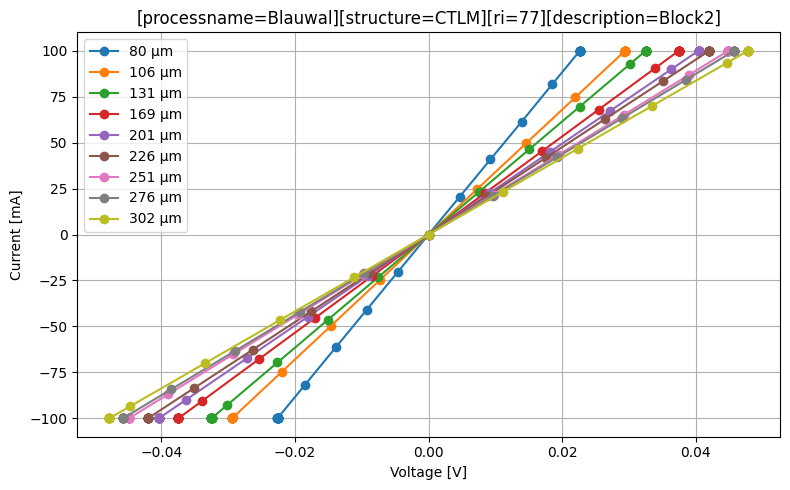

In [4]:
plt.figure(figsize=(8, 5))

for key in list_of_measurements.keys():
    # plt.plot(list_of_measurements[key]['Vin'], list_of_measurements[key]['Iin']*1000, label=key)
    plt.plot(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin']*1000, 'o-', label=f"{key} µm")

plt.xlabel("Voltage [V]")
plt.ylabel("Current [mA]")
# plt.xlim(-0.5, 0.5)
plt.title(name)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(folder_path, 'IV.png'), bbox_inches='tight')

In [5]:
def get_lin_fit(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept
    r_squared = 1- np.sum((y - y_fit)**2)/(np.sum((y - np.mean(y))**2)) # R^2 = 1 - SS_res / SS_tot = 1 - (y-y_fit)^2/(y-mean(y))^2

    return slope, intercept, r_squared

### check lineartiy of individual measuremnts

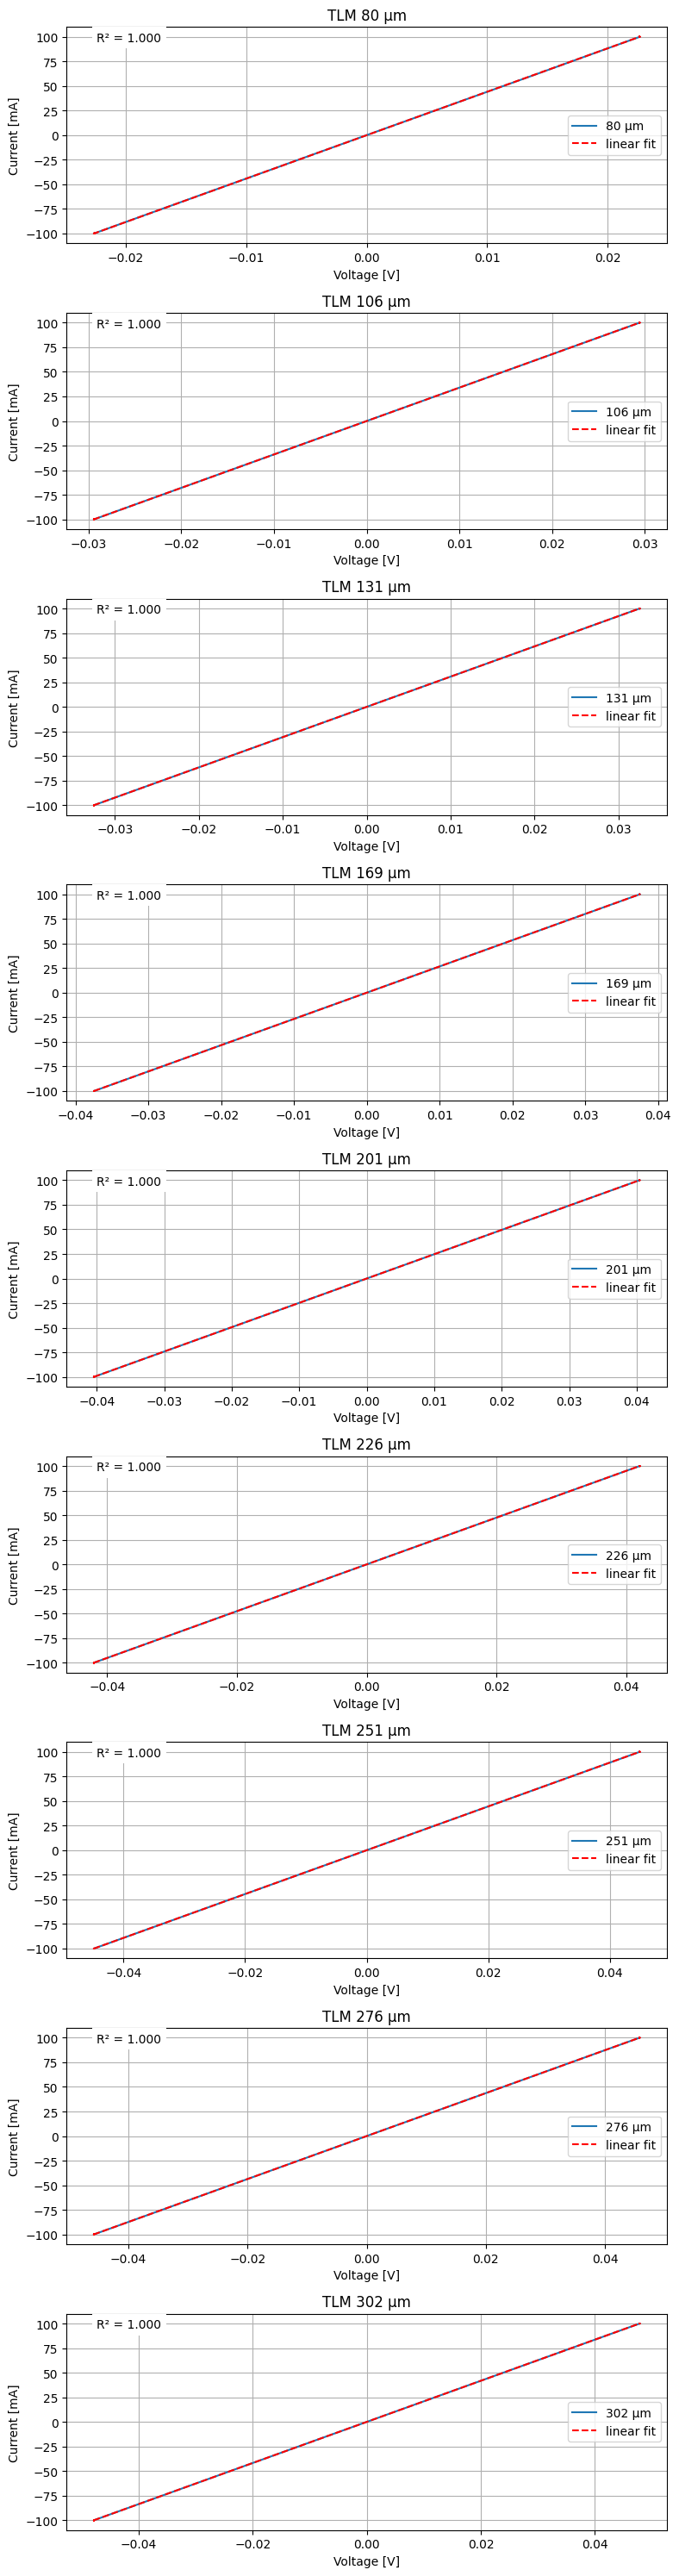

In [23]:
fig, axes = plt.subplots(len(list_of_measurements.keys()), 1, figsize=(8, 30))
axes = axes.flatten()

R_list = []
i = 0
for key in list_of_measurements.keys():
    ax = axes[i]
    i += 1
    ax.plot(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin']*1000, label=f"{key} µm")
    slope, intercept, r_squared = get_lin_fit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'])
    R_list.append((1/slope))  # in ohm
    ax.plot(list_of_measurements[key]['delta_V'], (slope * list_of_measurements[key]['delta_V'] + intercept)*1000, 'r--', label='linear fit')   # *1000 for mA
    ax.text(0.05, 0.95, 
        f"R² = {r_squared:.3f}",
        transform=ax.transAxes,  # position in relative axes coords
        verticalalignment='center',
        bbox=dict(facecolor="white", alpha=1, edgecolor="none"))  # background

    ax.set_title(f"TLM {key} µm")
    ax.set_ylabel("Current [mA]")
    ax.set_xlabel("Voltage [V]")
    ax.legend(loc='center right')
    ax.grid(True)


plt.tight_layout()
plt.show()

### plot TLM

[ 80 106 131 169 201 226 251 276 302]


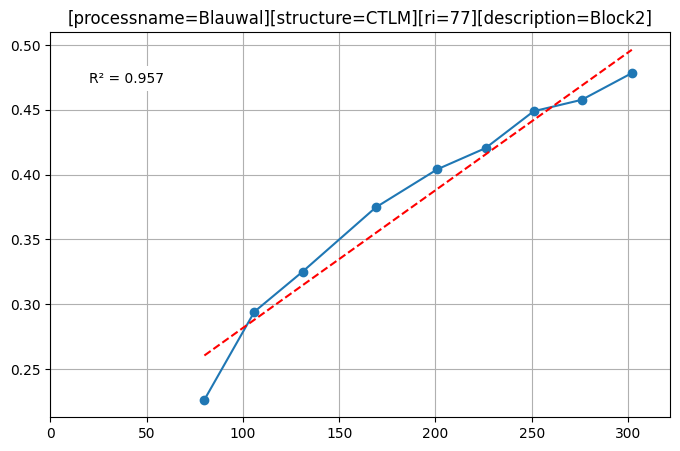

In [ ]:
plt.figure(figsize=(8, 5))

distances = list(map(int, list_of_measurements.keys()))
distances = np.array(distances)
print(distances)
plt.plot(distances, R_list, 'o-')

slope, intercept, r_squared = get_lin_fit(distances, R_list)
plt.plot(distances, (slope * distances + intercept), 'r--', label='linear fit')
plt.text(0.01, 1.25,
        f"R² = {r_squared:.3f}",
        transform=ax.transAxes,  # position in relative axes coords
        verticalalignment='center',
        bbox=dict(facecolor="white", alpha=1, edgecolor="none"))

plt.title(name)
plt.xlim(0, max(list_of_measurements.keys())+20)
plt.grid(True)
plt.show()

### calculate cTLM values
$L_T$, $R_{sh}$, $R_C$

In [7]:
def get_ctlm_params(lengths, resistances):
    slope, intercept = np.polyfit(lengths, resistances, 1)
    LT = -intercept / slope
    Rsh = slope
    Rc = intercept / 2

    return LT, Rsh, Rc